# SARIMAX: Mövsümi ARIMA Ekzogen Dəyişənlərlə
# SARIMAX: Seasonal ARIMA with Exogenous Variables

**Məqsəd / Goal:** Kredit satışını rüblük məlumatlarla və iqtisadi göstəricilərlə proqnozlaşdırmaq

**Nə zaman istifadə edilir / When to use:**
- Qısa tarixə malik tək aqreqat seriya / Single aggregate series with short history
- Faydalı ekzogen dəyişənlər var / Have useful exogenous variables
- Mövsümi nümunələr mövcuddur / Seasonal patterns exist

**Niyə yaxşıdır / Why good here:**
- Qısa rüblük seriyalar üçün uyğundur / Well-suited for short quarterly series
- AR və mövsümi strukturları açıq şəkildə modelləşdirir / Explicitly models AR and seasonal structures
- İqtisadi göstəriciləri daxil edə bilir / Can incorporate economic indicators

**Başlanğıc konfiqurasiya / Starting configuration:**
- order=(1,1,0) - sadə ARIMA komponentləri
- seasonal_order=(0,1,1,4) - rüblük mövsüm
- AIC və ya CV ilə tənzimləmə / Tune with AIC or CV

## 1. Kitabxanaların Yüklənməsi / Import Libraries

In [1]:
# Əsas kitabxanalar / Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# SARIMAX modeli / SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Qiymətləndirmə / Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Qrafik parametrləri / Plot settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')

print("✅ Kitabxanalar yükləndi / Libraries loaded")

✅ Kitabxanalar yükləndi / Libraries loaded


## 2. Məlumatların Yüklənməsi / Load Data

In [2]:
# Məlumatları oxuyaq / Read data
df = pd.read_csv('data/ml_ready_data.csv')

# Hədəf dəyişən / Target variable
target_col = 'Nağd_pul_kredit_satışı'

print("="*70)
print("MƏLUMAT HAQQINDA / ABOUT DATA")
print("="*70)
print(f"Ölçü / Shape: {df.shape}")
print(f"Dövr / Period: {df['Rüblər'].iloc[0]} → {df['Rüblər'].iloc[-1]}")
print(f"Müşahidələr / Observations: {len(df)}")
print(f"Rüblük məlumat / Quarterly data: 4 rüb/il")
print("="*70)

# İlk məlumatlar / First rows
print("\nİlk məlumatlar / First rows:")
df[['Rüblər', 'Year', 'Quarter', target_col]].head()

MƏLUMAT HAQQINDA / ABOUT DATA
Ölçü / Shape: (22, 29)
Dövr / Period: 2020 I → 2025 II
Müşahidələr / Observations: 22
Rüblük məlumat / Quarterly data: 4 rüb/il

İlk məlumatlar / First rows:


,Rüblər,Year,Quarter,Nağd_pul_kredit_satışı
0,2020 I,2020,1,46642.84149
1,2020 II,2020,2,15709.38447
2,2020 III,2020,3,51257.54777
3,2020 IV,2020,4,26391.99772
4,2021 I,2021,1,53293.77411


## 3. Ekzogen Dəyişənlərin Seçilməsi / Select Exogenous Variables

**Prinsip / Principle:** Az sayda, əsaslandırılmış dəyişənlər seçin

In [3]:
# Bütün sütunları görək / See all columns
print("Mövcud dəyişənlər / Available variables:")
print("="*70)
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

# İqtisadi göstəriciləri seçək / Select economic indicators
# Bunlar kredit satışına təsir edə bilər / These may influence credit sales
exog_candidates = [
    'GDP',  # GDP - ümumi iqtisadi vəziyyət / General economic condition
    'Əhalinin_nominal_gəlirləri',  # Population income - ödəmə qabiliyyəti / Payment ability
    'Əhalinin_banklardakı_əmanətləri',  # Bank deposits - savings level
    'Pul_bazası',  # Money base - money supply
]

print(f"\n📊 Seçilmiş ekzogen dəyişənlər / Selected exogenous variables:")
for i, var in enumerate(exog_candidates, 1):
    if var in df.columns:
        print(f"  {i}. {var}")
        print(f"     Orta / Mean: {df[var].mean():,.2f}")
        print(f"     Std: {df[var].std():,.2f}")
        print()

Mövcud dəyişənlər / Available variables:
 1. Rüblər
 2. Year
 3. Quarter
 4. Time_Index
 5. Nağd_pul_kredit_satışı
 6. GDP
 7. Dövlət_Gəlirləri
 8. Dövlət_Xərcləri
 9. Əhalinin_nominal_gəlirləri
10. Əhalinin_banklardakı_əmanətləri
11. Orta_aylıq_əməkhaqqı
12. Xarici_ticarət_dövriyyəsi
13. İxrac
14. İdxal
15. Pul_bazası
16. Oil_Price
17. Tikinti-quraşdırma_işlərinə_sərf_edilmiş_vəsait
18. İstehlak_xərcləri
19. Yaşayış_evlərinin_tikintisinə_yönəldilmiş_investisiyalar
20. Mənzil_qiymətləri
21. Müştərilərə_verilmiş_kreditlər
22. NPLs
23. ROA
24. ROE
25. Net_Interest_Margin
26. Efficiency_Ratio
27. Loan-to-Deposit_Ratio
28. Müştəri_sayı
29. Uçot_faiz_dərəcəsi

📊 Seçilmiş ekzogen dəyişənlər / Selected exogenous variables:
  1. GDP
     Orta / Mean: 27,773,990.91
     Std: 6,159,270.64

  2. Əhalinin_nominal_gəlirləri
     Orta / Mean: 17,532,436.36
     Std: 3,021,765.58

  3. Əhalinin_banklardakı_əmanətləri
     Orta / Mean: 11,254,740.91
     Std: 2,616,223.06

  4. Pul_bazası
     Orta / 

## 4. Məlumatların Hazırlanması / Prepare Data

In [4]:
# Hədəf seriya / Target series
y = df[target_col].copy()

# Ekzogen dəyişənlər / Exogenous variables
# Yalnız mövcud olanları götürək / Only take available ones
available_exog = [col for col in exog_candidates if col in df.columns]
X_exog = df[available_exog].copy()

print("Hədəf seriya / Target series:")
print(f"  Adı / Name: {target_col}")
print(f"  Ölçü / Size: {len(y)}")
print(f"  Orta / Mean: {y.mean():,.2f}")
print(f"  Std: {y.std():,.2f}")

print(f"\nEkzogen dəyişənlər / Exogenous variables:")
print(f"  Say / Count: {len(available_exog)}")
print(f"  Ölçü / Shape: {X_exog.shape}")
print(f"  Dəyişənlər / Variables: {', '.join(available_exog)}")

Hədəf seriya / Target series:
  Adı / Name: Nağd_pul_kredit_satışı
  Ölçü / Size: 22
  Orta / Mean: 80,612.82
  Std: 32,218.08

Ekzogen dəyişənlər / Exogenous variables:
  Say / Count: 4
  Ölçü / Shape: (22, 4)
  Dəyişənlər / Variables: GDP, Əhalinin_nominal_gəlirləri, Əhalinin_banklardakı_əmanətləri, Pul_bazası


## 5. Vizual Analiz: Zaman Seriyası / Visual Analysis: Time Series

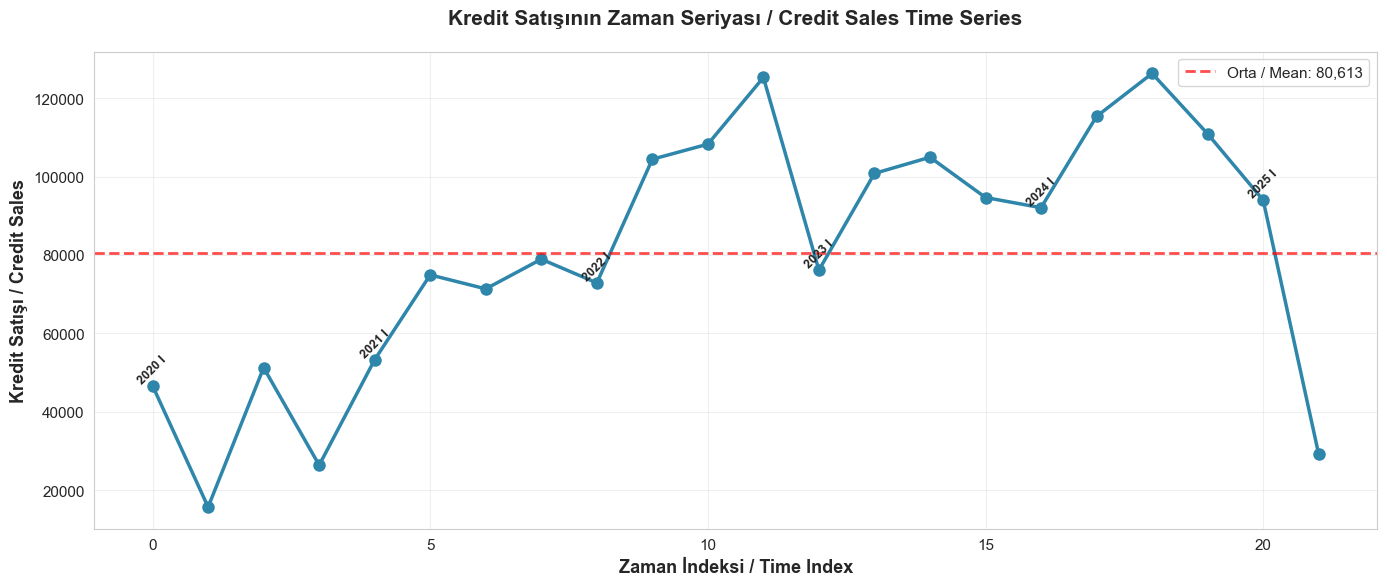

✅ Zaman seriyası qrafiki / Time series chart displayed


In [5]:
# Qrafik 1: Kredit satışının zamanla dəyişməsi / Chart 1: Credit sales over time
plt.figure(figsize=(14, 6))

plt.plot(range(len(y)), y.values, 'o-', color='#2E86AB', linewidth=2.5, markersize=8)

# Orta xətt / Mean line
plt.axhline(y=y.mean(), color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Orta / Mean: {y.mean():,.0f}')

# Rüb etiketləri / Quarter labels
for i in range(0, len(df), 4):  # Hər ilin birinci rübü / First quarter of each year
    if i < len(df):
        plt.text(i, y.iloc[i], df['Rüblər'].iloc[i], 
                fontsize=9, ha='center', va='bottom', rotation=45, fontweight='bold')

plt.xlabel('Zaman İndeksi / Time Index', fontsize=13, fontweight='bold')
plt.ylabel('Kredit Satışı / Credit Sales', fontsize=13, fontweight='bold')
plt.title('Kredit Satışının Zaman Seriyası / Credit Sales Time Series', 
         fontsize=15, fontweight='bold', pad=20)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Zaman seriyası qrafiki / Time series chart displayed")

## 6. Vizual Analiz: Mövsümi Nümunə / Visual Analysis: Seasonal Pattern

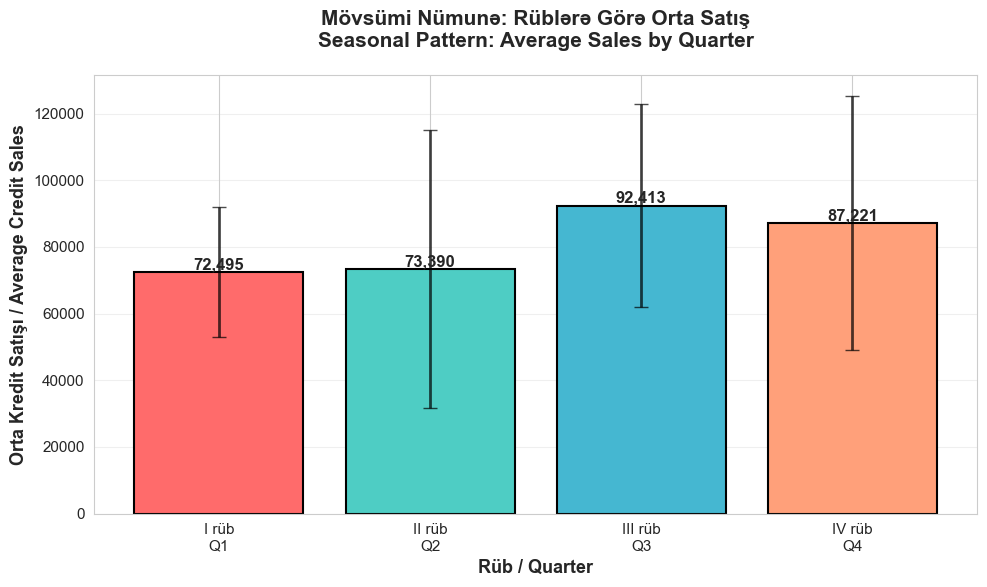

✅ Mövsümi nümunə qrafiki / Seasonal pattern chart displayed


In [6]:
# Qrafik 2: Rüblərə görə orta satış / Chart 2: Average sales by quarter
plt.figure(figsize=(10, 6))

quarterly_avg = df.groupby('Quarter')[target_col].agg(['mean', 'std'])

bars = plt.bar(quarterly_avg.index, quarterly_avg['mean'], 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'],
               edgecolor='black', linewidth=1.5)

# Xəta çubuqları / Error bars
plt.errorbar(quarterly_avg.index, quarterly_avg['mean'], 
            yerr=quarterly_avg['std'], fmt='none', 
            color='black', capsize=5, linewidth=2, alpha=0.7)

plt.xlabel('Rüb / Quarter', fontsize=13, fontweight='bold')
plt.ylabel('Orta Kredit Satışı / Average Credit Sales', fontsize=13, fontweight='bold')
plt.title('Mövsümi Nümunə: Rüblərə Görə Orta Satış\nSeasonal Pattern: Average Sales by Quarter', 
         fontsize=15, fontweight='bold', pad=20)
plt.xticks([1, 2, 3, 4], ['I rüb\nQ1', 'II rüb\nQ2', 'III rüb\nQ3', 'IV rüb\nQ4'], fontsize=11)
plt.grid(axis='y', alpha=0.3)

# Dəyərləri göstər / Show values
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print("✅ Mövsümi nümunə qrafiki / Seasonal pattern chart displayed")

## 7. ACF və PACF Analizi / ACF and PACF Analysis

**ACF:** Avtokorrelyasiya funksiyası - MA sifarişini müəyyənləşdirir

**PACF:** Qismən avtokorrelyasiya - AR sifarişini müəyyənləşdirir

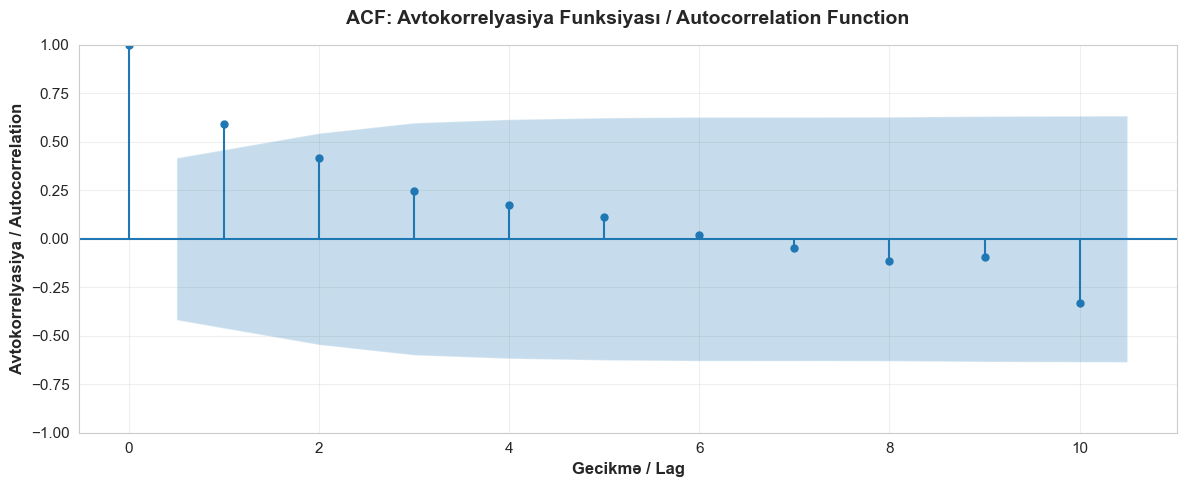

📊 ACF qrafiki: MA(q) sifarişini müəyyənləşdirmək üçün
   ACF chart: To determine MA(q) order


In [7]:
# Qrafik 3: ACF (Autocorrelation Function)
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(y, lags=10, ax=ax, alpha=0.05)
ax.set_xlabel('Gecikmə / Lag', fontsize=12, fontweight='bold')
ax.set_ylabel('Avtokorrelyasiya / Autocorrelation', fontsize=12, fontweight='bold')
ax.set_title('ACF: Avtokorrelyasiya Funksiyası / Autocorrelation Function', 
            fontsize=14, fontweight='bold', pad=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📊 ACF qrafiki: MA(q) sifarişini müəyyənləşdirmək üçün")
print("   ACF chart: To determine MA(q) order")

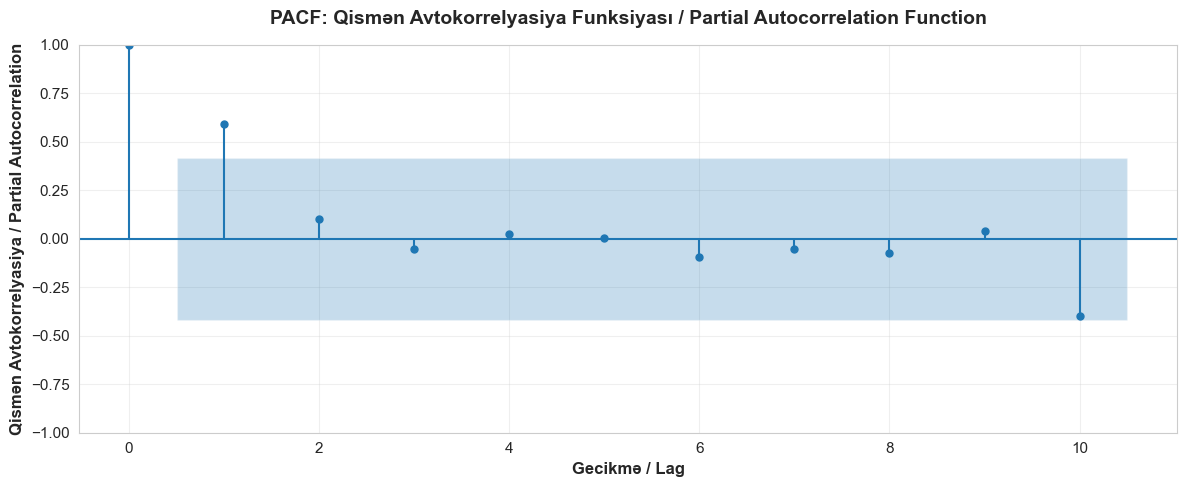

📊 PACF qrafiki: AR(p) sifarişini müəyyənləşdirmək üçün
   PACF chart: To determine AR(p) order


In [8]:
# Qrafik 4: PACF (Partial Autocorrelation Function)
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(y, lags=10, ax=ax, alpha=0.05)
ax.set_xlabel('Gecikmə / Lag', fontsize=12, fontweight='bold')
ax.set_ylabel('Qismən Avtokorrelyasiya / Partial Autocorrelation', fontsize=12, fontweight='bold')
ax.set_title('PACF: Qismən Avtokorrelyasiya Funksiyası / Partial Autocorrelation Function', 
            fontsize=14, fontweight='bold', pad=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📊 PACF qrafiki: AR(p) sifarişini müəyyənləşdirmək üçün")
print("   PACF chart: To determine AR(p) order")

## 8. Məlumatların Bölünməsi / Split Data

**Qeyd / Note:** Zaman seriyası üçün xronoloji bölgü vacibdir

In [9]:
# 80/20 bölgü / 80/20 split
split_point = int(len(df) * 0.8)

# Hədəf / Target
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

# Ekzogen dəyişənlər / Exogenous variables
X_train = X_exog.iloc[:split_point]
X_test = X_exog.iloc[split_point:]

print("="*70)
print("MƏLUMAT BÖLGÜsÜ / DATA SPLIT")
print("="*70)
print(f"Təlim / Train: {len(y_train)} müşahidə")
print(f"  Dövr / Period: {df['Rüblər'].iloc[0]} → {df['Rüblər'].iloc[split_point-1]}")
print()
print(f"Test: {len(y_test)} müşahidə")
print(f"  Dövr / Period: {df['Rüblər'].iloc[split_point]} → {df['Rüblər'].iloc[-1]}")
print()
print(f"Ekzogen dəyişənlər / Exogenous variables: {X_train.shape[1]}")
print("="*70)

MƏLUMAT BÖLGÜsÜ / DATA SPLIT
Təlim / Train: 17 müşahidə
  Dövr / Period: 2020 I → 2024 I

Test: 5 müşahidə
  Dövr / Period: 2024 II  → 2025 II

Ekzogen dəyişənlər / Exogenous variables: 4


## 9. SARIMAX Model 1: Sadə Başlanğıc / Simple Baseline

**Konfiqurasiya / Configuration:**
- order=(1,1,0): AR(1), 1 fərq, MA(0)
- seasonal_order=(0,1,1,4): Mövsümi MA(1), rüblük

In [10]:
# Model 1: Sadə SARIMAX / Simple SARIMAX
print("MODEL 1: Sadə SARIMAX öyrədilir...")
print("Training simple SARIMAX...")
print()

model_1 = SARIMAX(
    y_train,
    exog=X_train,
    order=(1, 1, 0),
    seasonal_order=(0, 1, 1, 4),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_1 = model_1.fit(disp=False)

# Təlim proqnozları / Train predictions
train_pred_1 = results_1.fittedvalues

# Test proqnozları / Test predictions
test_pred_1 = results_1.forecast(steps=len(y_test), exog=X_test)

# Qiymətləndirmə / Evaluation
valid_idx = ~np.isnan(train_pred_1)
train_r2_1 = r2_score(y_train[valid_idx], train_pred_1[valid_idx])
test_r2_1 = r2_score(y_test, test_pred_1)
test_mae_1 = mean_absolute_error(y_test, test_pred_1)
test_rmse_1 = np.sqrt(mean_squared_error(y_test, test_pred_1))

print("="*70)
print("MODEL 1 NƏTİCƏLƏRİ / RESULTS")
print("="*70)
print(f"Konfiqurasiya / Configuration: order=(1,1,0), seasonal=(0,1,1,4)")
print()
print(f"Təlim R² / Train R²:  {train_r2_1:.4f}")
print(f"Test R²:              {test_r2_1:.4f}")
print(f"Test MAE:             {test_mae_1:,.2f}")
print(f"Test RMSE:            {test_rmse_1:,.2f}")
print(f"AIC:                  {results_1.aic:.2f}")
print(f"BIC:                  {results_1.bic:.2f}")
print("="*70)

MODEL 1: Sadə SARIMAX öyrədilir...
Training simple SARIMAX...

MODEL 1 NƏTİCƏLƏRİ / RESULTS
Konfiqurasiya / Configuration: order=(1,1,0), seasonal=(0,1,1,4)

Təlim R² / Train R²:  -10.0931
Test R²:              -3.3725
Test MAE:             53,275.31
Test RMSE:            72,307.44
AIC:                  164.63
BIC:                  164.26


## 10. Vizualizasiya: Model 1 Nəticələri / Visualization: Model 1 Results

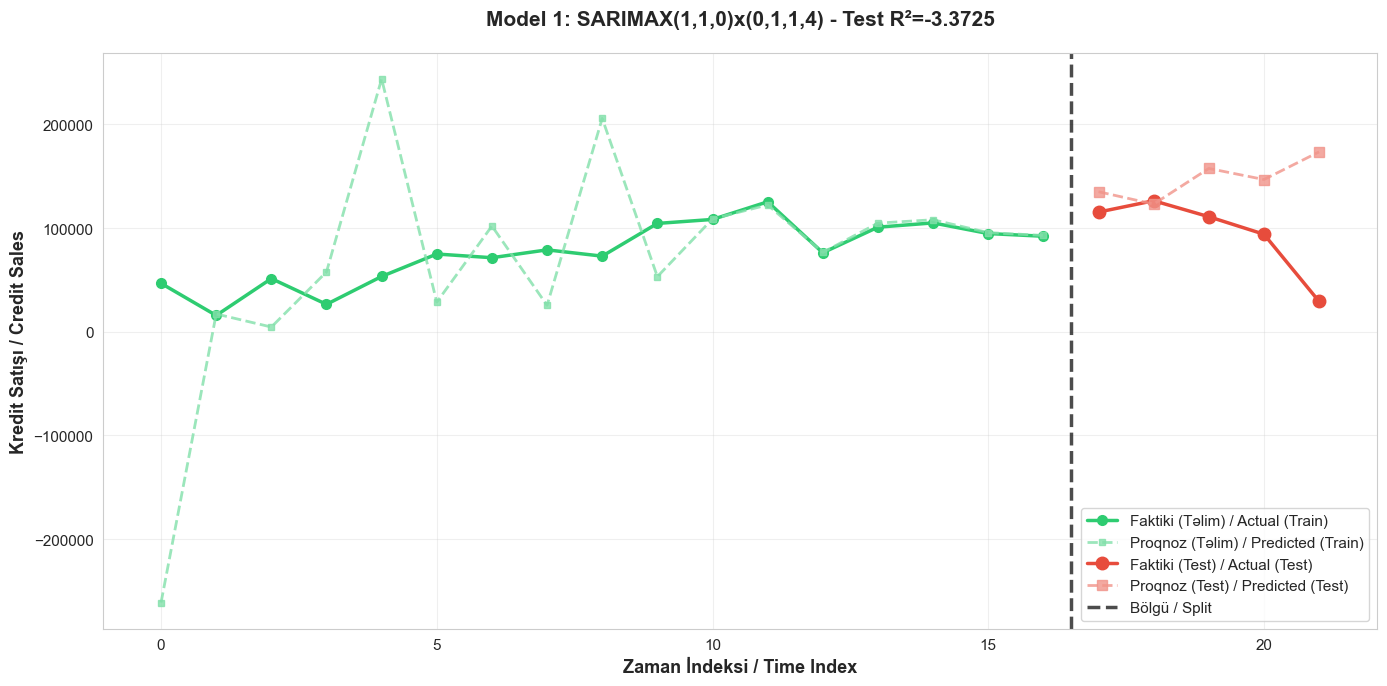

✅ Model 1 qrafiki göstərildi / Model 1 chart displayed


In [11]:
# Qrafik 5: Model 1 - Faktiki vs Proqnoz
plt.figure(figsize=(14, 7))

# Təlim məlumatları / Training data
plt.plot(range(len(y_train)), y_train.values, 'o-', 
         label='Faktiki (Təlim) / Actual (Train)', 
         color='#2ECC71', linewidth=2.5, markersize=7)
plt.plot(range(len(y_train)), train_pred_1, 's--', 
         label='Proqnoz (Təlim) / Predicted (Train)', 
         color='#82E0AA', linewidth=2, markersize=5, alpha=0.8)

# Test məlumatları / Test data
test_start = len(y_train)
plt.plot(range(test_start, test_start + len(y_test)), y_test.values, 'o-', 
         label='Faktiki (Test) / Actual (Test)', 
         color='#E74C3C', linewidth=2.5, markersize=9)
plt.plot(range(test_start, test_start + len(y_test)), test_pred_1, 's--', 
         label='Proqnoz (Test) / Predicted (Test)', 
         color='#F1948A', linewidth=2, markersize=7, alpha=0.8)

# Bölgü xətti / Split line
plt.axvline(x=test_start-0.5, color='black', linestyle='--', 
           linewidth=2.5, label='Bölgü / Split', alpha=0.7)

plt.xlabel('Zaman İndeksi / Time Index', fontsize=13, fontweight='bold')
plt.ylabel('Kredit Satışı / Credit Sales', fontsize=13, fontweight='bold')
plt.title(f'Model 1: SARIMAX(1,1,0)x(0,1,1,4) - Test R²={test_r2_1:.4f}', 
         fontsize=15, fontweight='bold', pad=20)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Model 1 qrafiki göstərildi / Model 1 chart displayed")

## 11. SARIMAX Model 2: Genişləndirilmiş / Extended

**Konfiqurasiya / Configuration:**
- order=(1,1,1): AR(1), 1 fərq, MA(1)
- seasonal_order=(1,1,1,4): Tam mövsümi komponentlər

In [12]:
# Model 2: Genişləndirilmiş SARIMAX / Extended SARIMAX
print("MODEL 2: Genişləndirilmiş SARIMAX öyrədilir...")
print("Training extended SARIMAX...")
print()

model_2 = SARIMAX(
    y_train,
    exog=X_train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 4),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_2 = model_2.fit(disp=False)

# Proqnozlar / Predictions
train_pred_2 = results_2.fittedvalues
test_pred_2 = results_2.forecast(steps=len(y_test), exog=X_test)

# Qiymətləndirmə / Evaluation
valid_idx = ~np.isnan(train_pred_2)
train_r2_2 = r2_score(y_train[valid_idx], train_pred_2[valid_idx])
test_r2_2 = r2_score(y_test, test_pred_2)
test_mae_2 = mean_absolute_error(y_test, test_pred_2)
test_rmse_2 = np.sqrt(mean_squared_error(y_test, test_pred_2))

print("="*70)
print("MODEL 2 NƏTİCƏLƏRİ / RESULTS")
print("="*70)
print(f"Konfiqurasiya / Configuration: order=(1,1,1), seasonal=(1,1,1,4)")
print()
print(f"Təlim R² / Train R²:  {train_r2_2:.4f}")
print(f"Test R²:              {test_r2_2:.4f}")
print(f"Test MAE:             {test_mae_2:,.2f}")
print(f"Test RMSE:            {test_rmse_2:,.2f}")
print(f"AIC:                  {results_2.aic:.2f}")
print(f"BIC:                  {results_2.bic:.2f}")
print("="*70)

MODEL 2: Genişləndirilmiş SARIMAX öyrədilir...
Training extended SARIMAX...



MODEL 2 NƏTİCƏLƏRİ / RESULTS
Konfiqurasiya / Configuration: order=(1,1,1), seasonal=(1,1,1,4)

Təlim R² / Train R²:  -12.3409
Test R²:              -4.2048
Test MAE:             59,102.10
Test RMSE:            78,889.57
AIC:                  144.75
BIC:                  142.88


/Users/ismatsamadov/.pyenv/versions/myenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## 12. Vizualizasiya: Model 2 Nəticələri / Visualization: Model 2 Results

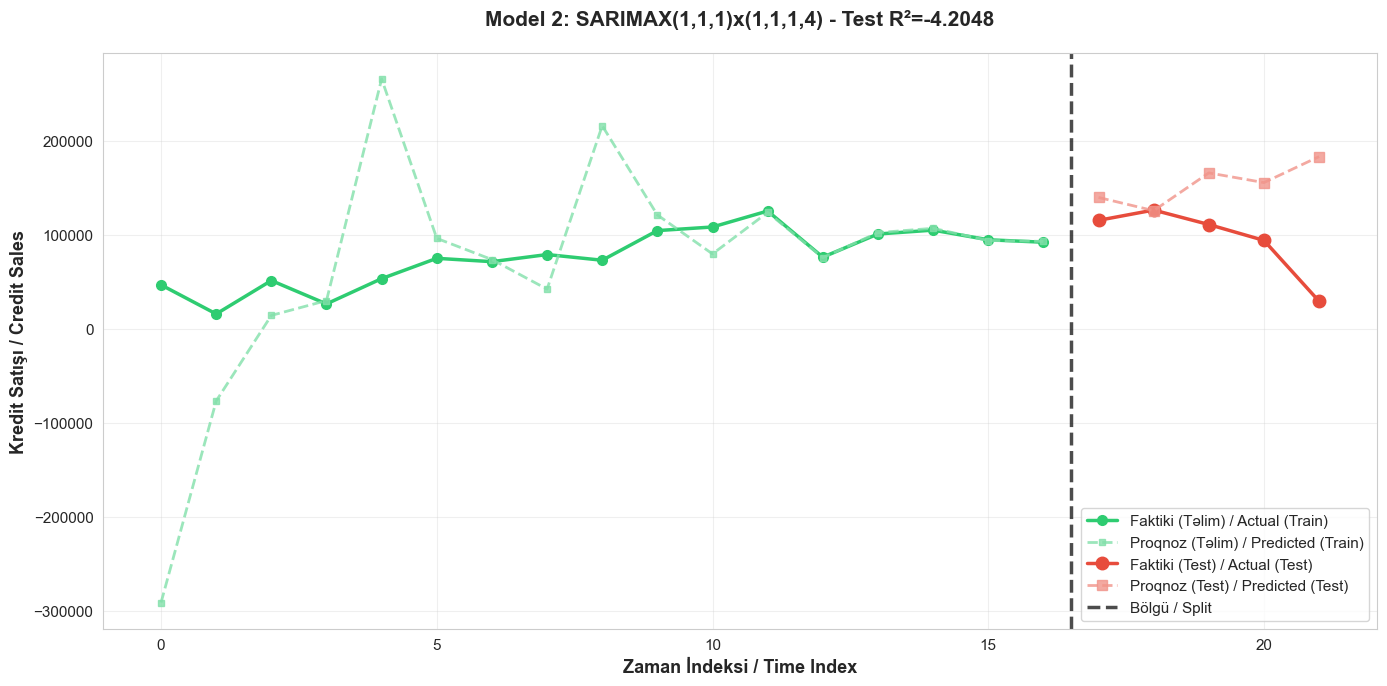

✅ Model 2 qrafiki göstərildi / Model 2 chart displayed


In [13]:
# Qrafik 6: Model 2 - Faktiki vs Proqnoz
plt.figure(figsize=(14, 7))

# Təlim məlumatları / Training data
plt.plot(range(len(y_train)), y_train.values, 'o-', 
         label='Faktiki (Təlim) / Actual (Train)', 
         color='#2ECC71', linewidth=2.5, markersize=7)
plt.plot(range(len(y_train)), train_pred_2, 's--', 
         label='Proqnoz (Təlim) / Predicted (Train)', 
         color='#82E0AA', linewidth=2, markersize=5, alpha=0.8)

# Test məlumatları / Test data
test_start = len(y_train)
plt.plot(range(test_start, test_start + len(y_test)), y_test.values, 'o-', 
         label='Faktiki (Test) / Actual (Test)', 
         color='#E74C3C', linewidth=2.5, markersize=9)
plt.plot(range(test_start, test_start + len(y_test)), test_pred_2, 's--', 
         label='Proqnoz (Test) / Predicted (Test)', 
         color='#F1948A', linewidth=2, markersize=7, alpha=0.8)

# Bölgü xətti / Split line
plt.axvline(x=test_start-0.5, color='black', linestyle='--', 
           linewidth=2.5, label='Bölgü / Split', alpha=0.7)

plt.xlabel('Zaman İndeksi / Time Index', fontsize=13, fontweight='bold')
plt.ylabel('Kredit Satışı / Credit Sales', fontsize=13, fontweight='bold')
plt.title(f'Model 2: SARIMAX(1,1,1)x(1,1,1,4) - Test R²={test_r2_2:.4f}', 
         fontsize=15, fontweight='bold', pad=20)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Model 2 qrafiki göstərildi / Model 2 chart displayed")

## 13. Modellərin Müqayisəsi / Model Comparison

In [14]:
# Müqayisə cədvəli / Comparison table
comparison = pd.DataFrame({
    'Model': [
        'SARIMAX(1,1,0)x(0,1,1,4)',
        'SARIMAX(1,1,1)x(1,1,1,4)'
    ],
    'Order': ['(1,1,0)', '(1,1,1)'],
    'Seasonal': ['(0,1,1,4)', '(1,1,1,4)'],
    'Təlim R²': [train_r2_1, train_r2_2],
    'Test R²': [test_r2_1, test_r2_2],
    'Test MAE': [test_mae_1, test_mae_2],
    'Test RMSE': [test_rmse_1, test_rmse_2],
    'AIC': [results_1.aic, results_2.aic],
    'BIC': [results_1.bic, results_2.bic]
})

comparison = comparison.sort_values('Test R²', ascending=False)

print("="*90)
print("SARIMAX MODELLƏRİNİN MÜQAYİSƏSİ / SARIMAX MODELS COMPARISON")
print("="*90)
print(comparison.to_string(index=False))
print("="*90)

best_model = comparison.iloc[0]
print(f"\n🏆 Ən yaxşı model / Best model: {best_model['Model']}")
print(f"   Test R²: {best_model['Test R²']:.4f}")
print(f"   Test MAE: {best_model['Test MAE']:,.2f}")
print(f"   AIC: {best_model['AIC']:.2f} (aşağı daha yaxşı / lower is better)")

SARIMAX MODELLƏRİNİN MÜQAYİSƏSİ / SARIMAX MODELS COMPARISON
                   Model   Order  Seasonal   Təlim R²   Test R²     Test MAE    Test RMSE        AIC        BIC
SARIMAX(1,1,0)x(0,1,1,4) (1,1,0) (0,1,1,4) -10.093133 -3.372512 53275.313075 72307.443789 164.633687 164.255058
SARIMAX(1,1,1)x(1,1,1,4) (1,1,1) (1,1,1,4) -12.340902 -4.204802 59102.096156 78889.574964 144.753779 142.879614

🏆 Ən yaxşı model / Best model: SARIMAX(1,1,0)x(0,1,1,4)
   Test R²: -3.3725
   Test MAE: 53,275.31
   AIC: 164.63 (aşağı daha yaxşı / lower is better)


## 14. Vizualizasiya: Test R² Müqayisəsi / Visualization: Test R² Comparison

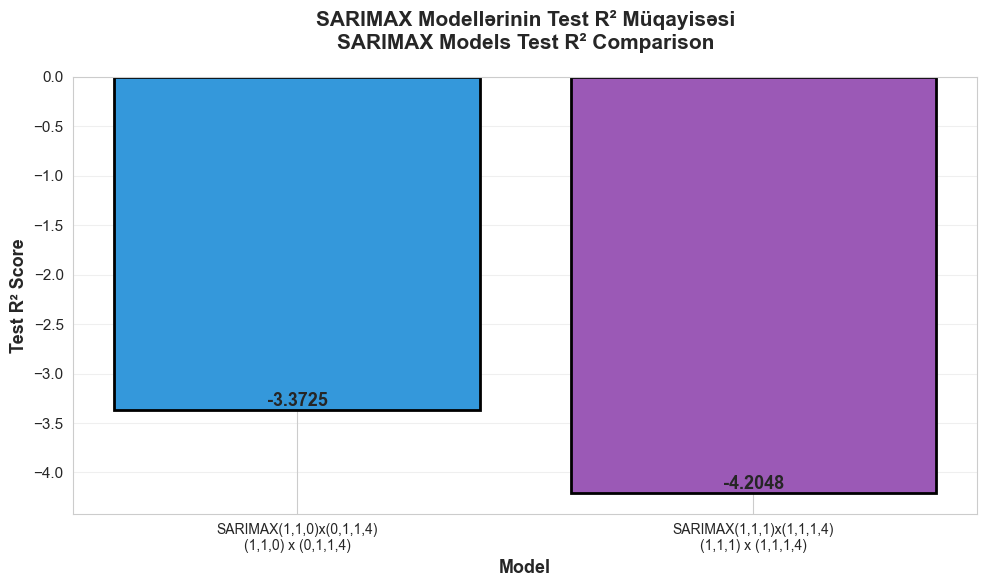

✅ Test R² müqayisə qrafiki / Test R² comparison chart displayed


In [15]:
# Qrafik 7: Test R² müqayisəsi
plt.figure(figsize=(10, 6))

bars = plt.bar(range(len(comparison)), comparison['Test R²'], 
               color=['#3498DB', '#9B59B6'], 
               edgecolor='black', linewidth=2)

plt.xlabel('Model', fontsize=13, fontweight='bold')
plt.ylabel('Test R² Score', fontsize=13, fontweight='bold')
plt.title('SARIMAX Modellərinin Test R² Müqayisəsi\nSARIMAX Models Test R² Comparison', 
         fontsize=15, fontweight='bold', pad=20)
plt.xticks(range(len(comparison)), 
          [f"{row['Model']}\n{row['Order']} x {row['Seasonal']}" 
           for _, row in comparison.iterrows()],
          fontsize=10)
plt.grid(axis='y', alpha=0.3)

# Dəyərləri göstər / Show values
for i, (bar, val) in enumerate(zip(bars, comparison['Test R²'])):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.4f}', ha='center', va='bottom', 
            fontweight='bold', fontsize=13)

plt.tight_layout()
plt.show()

print("✅ Test R² müqayisə qrafiki / Test R² comparison chart displayed")

## 15. Vizualizasiya: AIC Müqayisəsi / Visualization: AIC Comparison

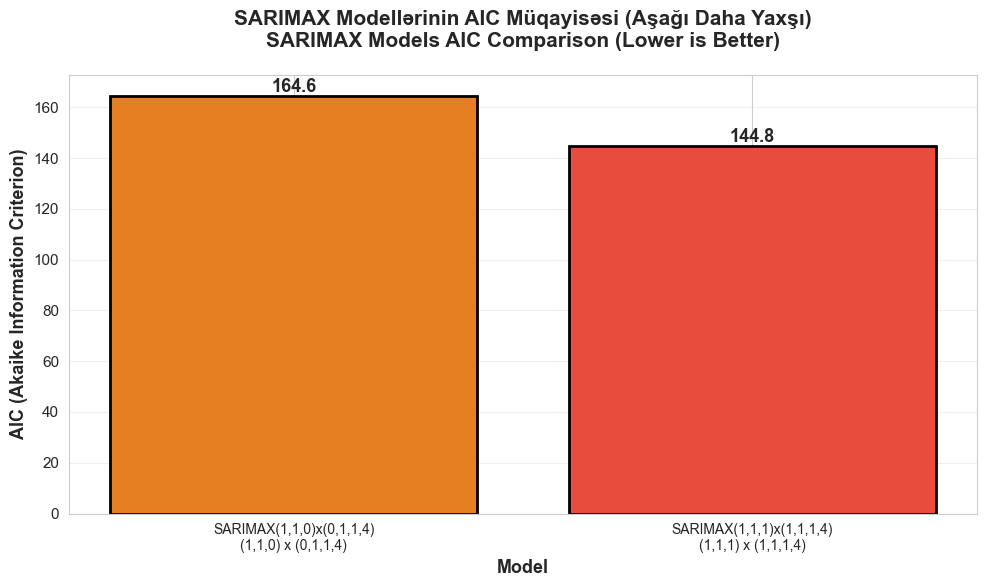

✅ AIC müqayisə qrafiki / AIC comparison chart displayed


In [16]:
# Qrafik 8: AIC müqayisəsi (aşağı daha yaxşı / lower is better)
plt.figure(figsize=(10, 6))

bars = plt.bar(range(len(comparison)), comparison['AIC'], 
               color=['#E67E22', '#E74C3C'], 
               edgecolor='black', linewidth=2)

plt.xlabel('Model', fontsize=13, fontweight='bold')
plt.ylabel('AIC (Akaike Information Criterion)', fontsize=13, fontweight='bold')
plt.title('SARIMAX Modellərinin AIC Müqayisəsi (Aşağı Daha Yaxşı)\nSARIMAX Models AIC Comparison (Lower is Better)', 
         fontsize=15, fontweight='bold', pad=20)
plt.xticks(range(len(comparison)), 
          [f"{row['Model']}\n{row['Order']} x {row['Seasonal']}" 
           for _, row in comparison.iterrows()],
          fontsize=10)
plt.grid(axis='y', alpha=0.3)

# Dəyərləri göstər / Show values
for i, (bar, val) in enumerate(zip(bars, comparison['AIC'])):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}', ha='center', va='bottom', 
            fontweight='bold', fontsize=13)

plt.tight_layout()
plt.show()

print("✅ AIC müqayisə qrafiki / AIC comparison chart displayed")

## 16. Model Diaqnostikası / Model Diagnostics

**Ən yaxşı modelin qalıqlarını yoxlayaq / Check residuals of best model**

In [17]:
# Ən yaxşı modeli seçək / Select best model
if test_r2_1 > test_r2_2:
    best_results = results_1
    best_name = "Model 1: SARIMAX(1,1,0)x(0,1,1,4)"
else:
    best_results = results_2
    best_name = "Model 2: SARIMAX(1,1,1)x(1,1,1,4)"

print(f"\n🏆 Diaqnostika üçün seçildi / Selected for diagnostics:")
print(f"   {best_name}")
print()

# Qalıqlar / Residuals
residuals = best_results.resid

print("Qalıq statistikası / Residual statistics:")
print(f"  Orta / Mean: {residuals.mean():.4f} (0-a yaxın olmalı / should be close to 0)")
print(f"  Std: {residuals.std():.2f}")
print(f"  Min: {residuals.min():.2f}")
print(f"  Max: {residuals.max():.2f}")


🏆 Diaqnostika üçün seçildi / Selected for diagnostics:
   Model 1: SARIMAX(1,1,0)x(0,1,1,4)

Qalıq statistikası / Residual statistics:
  Orta / Mean: 6627.5968 (0-a yaxın olmalı / should be close to 0)
  Std: 99877.22
  Min: -190395.56
  Max: 307731.30


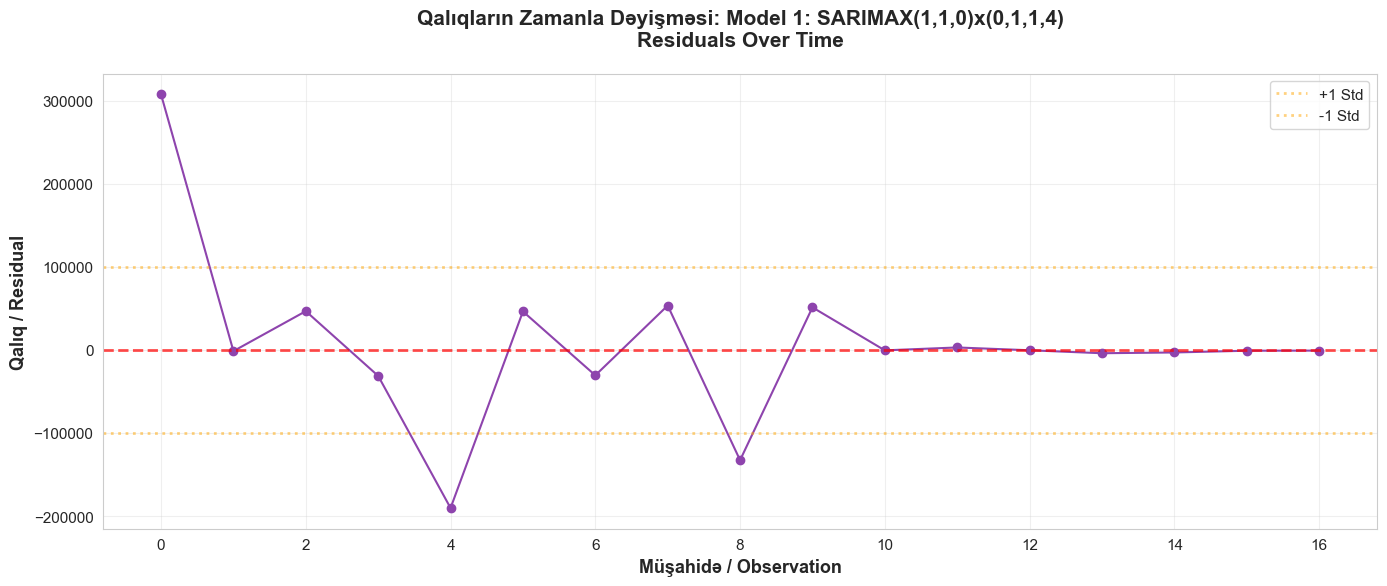

✅ Qalıq qrafiki göstərildi / Residual chart displayed
   İdeal: Qalıqlar 0 ətrafında təsadüfi paylanmalıdır
   Ideal: Residuals should be randomly distributed around 0


In [18]:
# Qrafik 9: Qalıqların zamanla dəyişməsi / Residuals over time
plt.figure(figsize=(14, 6))

plt.plot(residuals, 'o-', color='#8E44AD', linewidth=1.5, markersize=6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.axhline(y=residuals.std(), color='orange', linestyle=':', linewidth=2, alpha=0.5, label='+1 Std')
plt.axhline(y=-residuals.std(), color='orange', linestyle=':', linewidth=2, alpha=0.5, label='-1 Std')

plt.xlabel('Müşahidə / Observation', fontsize=13, fontweight='bold')
plt.ylabel('Qalıq / Residual', fontsize=13, fontweight='bold')
plt.title(f'Qalıqların Zamanla Dəyişməsi: {best_name}\nResiduals Over Time', 
         fontsize=15, fontweight='bold', pad=20)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Qalıq qrafiki göstərildi / Residual chart displayed")
print("   İdeal: Qalıqlar 0 ətrafında təsadüfi paylanmalıdır")
print("   Ideal: Residuals should be randomly distributed around 0")

## 17. Yekun Nəticələr və Tövsiyələr / Final Results and Recommendations

In [19]:
print("="*80)
print("YEKİN NƏTİCƏLƏR VƏ TÖVSİYƏLƏR / FINAL RESULTS AND RECOMMENDATIONS")
print("="*80)

print("\n📊 Məlumat / Data:")
print(f"   • Müşahidələr / Observations: {len(df)} (rüblük / quarterly)")
print(f"   • Təlim / Training: {len(y_train)}")
print(f"   • Test: {len(y_test)}")
print(f"   • Ekzogen dəyişənlər / Exogenous: {len(available_exog)}")

print("\n🏆 Ən yaxşı model / Best model:")
print(f"   • {best_model['Model']}")
print(f"   • Test R²: {best_model['Test R²']:.4f}")
print(f"   • Test MAE: {best_model['Test MAE']:,.2f}")
print(f"   • AIC: {best_model['AIC']:.2f}")

print("\n💡 Tövsiyələr / Recommendations:")
print("   ✓ SARIMAX mövsümi nümunələri tutmaq üçün yaxşıdır")
print("     SARIMAX is good for capturing seasonal patterns")
print()
print("   ✓ Ekzogen dəyişənlər modeli yaxşılaşdırır")
print("     Exogenous variables improve the model")
print()
print("   ✓ order=(1,1,0-1) və seasonal=(0-1,1,1,4) yaxşı başlanğıcdır")
print("     order=(1,1,0-1) and seasonal=(0-1,1,1,4) are good starting points")
print()
print("   ⚠️  Qısa tarix limitləşdirici amildir")
print("     Short history is a limiting factor")
print()
print("   ⚠️  Daha çox məlumat modelləri yaxşılaşdıra bilər")
print("     More data could improve models")

print("\n📈 Növbəti addımlar / Next steps:")
print("   1. Daha çox ekzogen dəyişənlər sınayın")
print("      Try more exogenous variables")
print()
print("   2. Grid search ilə optimal parametrlər tapın")
print("      Find optimal parameters with grid search")
print()
print("   3. Rolling window CV ilə modeli yoxlayın")
print("      Validate model with rolling window CV")

print("\n" + "="*80)
print("✅ SARIMAX ANALİZİ TAMAMLANDI / SARIMAX ANALYSIS COMPLETE")
print("="*80)

YEKİN NƏTİCƏLƏR VƏ TÖVSİYƏLƏR / FINAL RESULTS AND RECOMMENDATIONS

📊 Məlumat / Data:
   • Müşahidələr / Observations: 22 (rüblük / quarterly)
   • Təlim / Training: 17
   • Test: 5
   • Ekzogen dəyişənlər / Exogenous: 4

🏆 Ən yaxşı model / Best model:
   • SARIMAX(1,1,0)x(0,1,1,4)
   • Test R²: -3.3725
   • Test MAE: 53,275.31
   • AIC: 164.63

💡 Tövsiyələr / Recommendations:
   ✓ SARIMAX mövsümi nümunələri tutmaq üçün yaxşıdır
     SARIMAX is good for capturing seasonal patterns

   ✓ Ekzogen dəyişənlər modeli yaxşılaşdırır
     Exogenous variables improve the model

   ✓ order=(1,1,0-1) və seasonal=(0-1,1,1,4) yaxşı başlanğıcdır
     order=(1,1,0-1) and seasonal=(0-1,1,1,4) are good starting points

   ⚠️  Qısa tarix limitləşdirici amildir
     Short history is a limiting factor

   ⚠️  Daha çox məlumat modelləri yaxşılaşdıra bilər
     More data could improve models

📈 Növbəti addımlar / Next steps:
   1. Daha çox ekzogen dəyişənlər sınayın
      Try more exogenous variables

   2. 